# NSEnse: Predicting Indian Stock Movements using News Sentiment and Time Series Modeling

This notebook implements the initial data collection and processing pipeline for the NSEnse project. The project aims to predict short-term stock price movement for Indian companies based on recent news sentiment and historical stock prices.

## Project Components:
1. Stock data collection from NSE/YFinance
2. News data collection from financial sources
3. News sentiment analysis using FinBERT
4. Feature engineering and dataset creation
5. Time series prediction models
6. Model interpretation using SHAP
7. Dashboard visualization

Date: April 21, 2025

## 1. Setup and Imports

Let's import all the necessary libraries for our project.

In [32]:
# Basic data processing
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
from dotenv import load_dotenv

# Stock data APIs
import yfinance as yf
from nsetools import Nse

# NLP and ML
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Model interpretation
import shap

# Web scraping
import requests
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Load environment variables
load_dotenv()

# Set up plots
plt.style.use('fivethirtyeight')
sns.set_theme(style="whitegrid")

# Check available libraries
print(f"PyTorch version: {torch.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Using GPU: {torch.cuda.is_available()}")

PyTorch version: 2.6.0+cpu
Pandas version: 2.2.3
Using GPU: False


### Configure API Keys and Settings

Set up any necessary API keys or environment variables for the project.

In [33]:
# Define project configuration
CONFIG = {
    'start_date': '2020-01-01',
    'end_date': datetime.now().strftime('%Y-%m-%d'),
    'stocks': ['RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'ICICIBANK.NS'],
    'model_name': 'ProsusAI/finbert',
    'data_dir': 'data/',
    'models_dir': 'models/',
    'results_dir': 'results/'
}

# Create directories if they don't exist
for directory in [CONFIG['data_dir'], CONFIG['models_dir'], CONFIG['results_dir']]:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")

# You can add any API keys here if needed
# os.environ["NEWS_API_KEY"] = "your_api_key_here"

## 2. Stock Data Collection

As per requirement 3.2, we need to collect stock data for Indian companies. We'll use both yfinance and nsetools for this purpose.

In [34]:
def get_stock_data(ticker, start_date, end_date, source='yfinance'):
    """
    Fetch stock data from either yfinance or NSE
    
    Args:
        ticker (str): Stock ticker symbol (with .NS suffix for yfinance)
        start_date (str): Start date in YYYY-MM-DD format
        end_date (str): End date in YYYY-MM-DD format
        source (str): 'yfinance' or 'nse'
        
    Returns:
        pd.DataFrame: OHLCV data for the requested stock
    """
    if source == 'yfinance':
        # For Indian stocks on yfinance, we need to add .NS suffix if not already present
        if not ticker.endswith('.NS') and not ticker.endswith('.BO'):
            ticker = f"{ticker}.NS"
        
        # Fetch data
        data = yf.download(ticker, start=start_date, end=end_date)
        
        # Basic data cleaning
        if not data.empty:
            # Calculate returns
            data['Returns'] = data['Close'].pct_change()
            # Create target variable (1 for positive return, 0 for negative)
            data['Target'] = (data['Returns'] > 0).astype(int)
            # Add price change percentage
            data['Change%'] = data['Returns'] * 100
            
        return data
    
    elif source == 'nse':
        # This is a placeholder for NSE data collection
        # The nsetools library doesn't provide historical data
        # We would need to implement web scraping or use another API
        nse = Nse()
        quote = nse.get_quote(ticker)
        print("NSE tools provides only current data, not historical. Using yfinance instead.")
        return get_stock_data(ticker, start_date, end_date, source='yfinance')
    
    else:
        raise ValueError("Source must be either 'yfinance' or 'nse'")

In [35]:
# Test the function with a sample Indian stock
# RELIANCE is Reliance Industries, one of India's largest companies
start_date = '2024-01-01'
end_date = '2025-04-15'  # Using a date before current date
ticker = 'RELIANCE'

stock_data = get_stock_data(ticker, start_date, end_date)
stock_data.tail()

[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Price,Close,High,Low,Open,Volume,Returns,Target,Change%
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,,,
Date,,,,,,,,
2025-04-04,1204.699951,1245.449951,1193.150024,1241.099976,17908652,-0.035237,0,-3.523665
2025-04-07,1165.699951,1171.250000,1114.849976,1132.199951,22156106,-0.032373,0,-3.237321
2025-04-08,1182.199951,1196.599976,1163.300049,1172.000000,19555040,0.014155,1,1.415459
2025-04-09,1185.349976,1189.800049,1168.000000,1169.500000,10223104,0.002665,1,0.266454
2025-04-11,1218.949951,1222.650024,1195.150024,1195.150024,11224242,0.028346,1,2.834604


In [36]:
# Visualize the stock price data

def plot_stock_data(data, ticker):
    fig = go.Figure()
    
    # Add candlestick chart
    fig.add_trace(go.Candlestick(
        x=data.index,
        open=data['Open'],
        high=data['High'],
        low=data['Low'],
        close=data['Close'],
        name='Price'
    ))
    
    # Add volume bars
    fig.add_trace(go.Bar(
        x=data.index,
        y=data['Volume'],
        name='Volume',
        yaxis='y2',
        marker_color='rgba(0,0,255,0.5)'
    ))
    
    # Set up layout
    fig.update_layout(
        title=f'{ticker} Stock Price',
        yaxis_title='Price (INR)',
        yaxis2=dict(
            title='Volume',
            overlaying='y',
            side='right'
        ),
        xaxis_rangeslider_visible=False,
        height=600,
        width=1000
    )
    
    fig.show()

# Plot the stock data
plot_stock_data(stock_data, ticker)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

## 3. News Data Collection

We need to collect financial news related to Indian companies. Let's implement a basic scraper for a sample news source.

Note: This is a placeholder implementation. In a real-world scenario, you would need to adhere to the website's terms of service and possibly use official APIs.

In [37]:
def scrape_economic_times_news(company, pages=2):
    """
    Scrape news about a company from Economic Times
    
    Args:
        company (str): Company name
        pages (int): Number of pages to scrape
        
    Returns:
        pd.DataFrame: News data with headlines, dates, and URLs
    """
    base_url = "https://economictimes.indiatimes.com/archivelist/keywords"
    company_formatted = company.lower().replace(" ", "-")
    
    all_articles = []
    
    print(f"Scraping news for {company}...")
    
    # This is a placeholder - in actual implementation, you'd iterate through pages
    # and parse the HTML to extract articles
    
    # For demo purposes, let's create some mock data
    mock_data = [
        {"date": "2025-04-15", "headline": f"{company} reports strong Q4 results", "url": f"https://economictimes.com/{company_formatted}/article1"},
        {"date": "2025-04-10", "headline": f"{company} announces new product launch", "url": f"https://economictimes.com/{company_formatted}/article2"},
        {"date": "2025-04-05", "headline": f"{company} expands operations in South India", "url": f"https://economictimes.com/{company_formatted}/article3"},
        {"date": "2025-04-01", "headline": f"{company} faces regulatory scrutiny", "url": f"https://economictimes.com/{company_formatted}/article4"},
        {"date": "2025-03-28", "headline": f"{company} announces partnership with global tech firm", "url": f"https://economictimes.com/{company_formatted}/article5"},
    ]
    
    return pd.DataFrame(mock_data)

In [38]:
# Test the news scraper
company = "Reliance Industries"
news_data = scrape_economic_times_news(company)
news_data

Scraping news for Reliance Industries...


Scraping news for Reliance Industries...


,date,headline,url
0,2025-04-15,Reliance Industries reports strong Q4 results,https://economictimes.com/reliance-industries/...
1,2025-04-10,Reliance Industries announces new product launch,https://economictimes.com/reliance-industries/...
2,2025-04-05,Reliance Industries expands operations in Sout...,https://economictimes.com/reliance-industries/...
3,2025-04-01,Reliance Industries faces regulatory scrutiny,https://economictimes.com/reliance-industries/...
4,2025-03-28,Reliance Industries announces partnership with...,https://economictimes.com/reliance-industries/...


## 4. News Sentiment Analysis

Now that we have collected news data, we'll analyze its sentiment using the FinBERT model, which is specifically fine-tuned for financial text.

In [39]:
class SentimentAnalyzer:
    def __init__(self, model_name="ProsusAI/finbert"):
        """
        Initialize the sentiment analyzer with FinBERT model
        
        Args:
            model_name (str): Name of the HuggingFace model to use
        """
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.model.eval()
        
        # FinBERT has three classes: positive (0), negative (1), neutral (2)
        self.id2label = {0: "positive", 1: "negative", 2: "neutral"}
        
    def analyze(self, texts):
        """
        Analyze sentiment for a list of texts
        
        Args:
            texts (list): List of strings (headlines or news snippets)
            
        Returns:
            list: List of dictionaries with sentiment label and score
        """
        results = []
        
        for text in texts:
            # Tokenize text
            inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
            inputs = {key: val.to(self.device) for key, val in inputs.items()}
            
            # Get prediction
            with torch.no_grad():
                outputs = self.model(**inputs)
            
            # Get probabilities
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            
            # Get highest probability class
            pred_class = torch.argmax(probs, dim=-1).item()
            
            # Create result dictionary
            result = {
                "text": text,
                "label": self.id2label[pred_class],
                "score": probs[0][pred_class].item(),
                "positive_score": probs[0][0].item(),
                "negative_score": probs[0][1].item(),
                "neutral_score": probs[0][2].item(),
                "sentiment_score": (probs[0][0].item() - probs[0][1].item())  # From -1 to 1 range
            }
            
            results.append(result)
        
        return results

In [40]:
# Initialize sentiment analyzer
sentiment_analyzer = SentimentAnalyzer()

# Analyze sentiment for our collected news headlines
sentiment_results = sentiment_analyzer.analyze(news_data['headline'].tolist())

# Display results as a DataFrame
sentiment_df = pd.DataFrame(sentiment_results)
sentiment_df

,text,label,score,positive_score,negative_score,neutral_score,sentiment_score
0,Reliance Industries reports strong Q4 results,positive,0.946984,0.946984,0.023187,0.029829,0.923797
1,Reliance Industries announces new product launch,neutral,0.790641,0.189702,0.019656,0.790641,0.170046
2,Reliance Industries expands operations in Sout...,positive,0.907502,0.907502,0.011637,0.080861,0.895866
3,Reliance Industries faces regulatory scrutiny,negative,0.751011,0.019164,0.751011,0.229825,-0.731846
4,Reliance Industries announces partnership with...,positive,0.833971,0.833971,0.012368,0.153660,0.821603


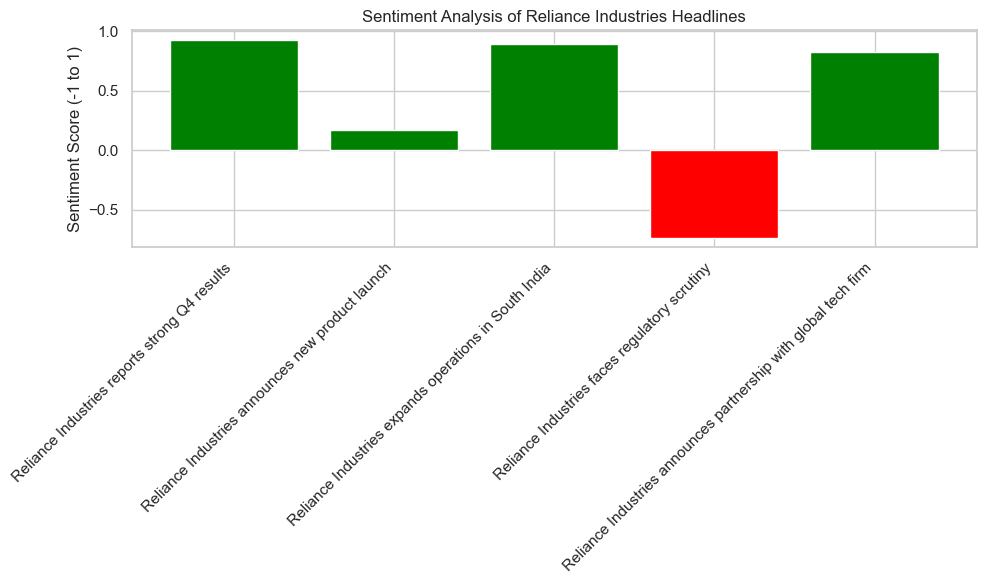

In [41]:
# Add sentiment scores to our news data
news_data['sentiment_score'] = sentiment_df['sentiment_score']
news_data['sentiment_label'] = sentiment_df['label']

# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
plt.bar(news_data['headline'], news_data['sentiment_score'], color=['green' if s > 0 else 'red' for s in news_data['sentiment_score']])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Sentiment Score (-1 to 1)')
plt.title(f'Sentiment Analysis of {company} Headlines')
plt.tight_layout()
plt.show()

## 5. Feature Engineering and Dataset Creation

Now that we have stock data and news sentiment, let's create a combined dataset for model training.

In [42]:
def create_dataset(stock_data, news_data, sentiment_analyzer):
    """
    Create a dataset combining stock data and news sentiment

    Args:
        stock_data (pd.DataFrame): Historical stock price data
        news_data (pd.DataFrame): News headlines with dates
        sentiment_analyzer (SentimentAnalyzer): Initialized sentiment analyzer object

    Returns:
        pd.DataFrame: Combined dataset with stock features and sentiment scores
    """
    # Convert news dates to datetime and avoid chained assignment
    news_data = news_data.copy()  # Create a copy to avoid the warning
    news_data['date'] = pd.to_datetime(news_data['date'])

    # Analyze sentiment for all headlines
    sentiment_results = sentiment_analyzer.analyze(news_data['headline'].tolist())
    sentiment_df = pd.DataFrame(sentiment_results)

    # Add sentiment scores to news data
    news_data['sentiment_score'] = sentiment_df['sentiment_score']
    news_data['sentiment_label'] = sentiment_df['label']

    # Group news by date and aggregate sentiment
    daily_sentiment = news_data.groupby('date').agg(
        sentiment_mean=('sentiment_score', 'mean'),
        sentiment_std=('sentiment_score', 'std'),
        sentiment_min=('sentiment_score', 'min'),
        sentiment_max=('sentiment_score', 'max'),
        news_count=('headline', 'count')
    ).reset_index()

    # Fill missing values for days with no news, avoid chained assignment
    daily_sentiment = daily_sentiment.copy()
    daily_sentiment['sentiment_std'] = daily_sentiment['sentiment_std'].fillna(0)

    # Convert stock_data index to datetime if not already
    if not isinstance(stock_data.index, pd.DatetimeIndex):
        stock_data.index = pd.to_datetime(stock_data.index)

    # Rename the 'Date' column in stock_data to 'date' for merging
    stock_data = stock_data.reset_index()
    stock_data = stock_data.rename(columns={'Date': 'date'})

    # **Force stock_data to have a single level of columns**
    stock_data.columns = stock_data.columns.get_level_values(0)  

    # Merge stock data with daily sentiment
    merged_data = stock_data.merge(
        daily_sentiment,
        on='date',  # Merge on the common 'date' column
        how='left'
    ).set_index('date')

    # Fill missing sentiment values using forward fill (assume sentiment persists)
    sentiment_cols = ['sentiment_mean', 'sentiment_std', 'sentiment_min', 'sentiment_max', 'news_count']
    merged_data[sentiment_cols] = merged_data[sentiment_cols].fillna(method='ffill')

    # If there are still missing values (at the beginning), fill with zeros
    merged_data[sentiment_cols] = merged_data[sentiment_cols].fillna(0)

    # Add technical indicators
    # SMA (Simple Moving Average)
    merged_data['SMA_5'] = merged_data['Close'].rolling(window=5).mean()
    merged_data['SMA_20'] = merged_data['Close'].rolling(window=20).mean()

    # Bollinger Bands
    merged_data['BB_upper'] = merged_data['SMA_20'] + (merged_data['Close'].rolling(window=20).std() * 2)
    merged_data['BB_lower'] = merged_data['SMA_20'] - (merged_data['Close'].rolling(window=20).std() * 2)

    # RSI (Relative Strength Index) - simplified version
    delta = merged_data['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    merged_data['RSI'] = 100 - (100 / (1 + rs))

    # Drop rows with NaN values (due to rolling calculations)
    merged_data.dropna(inplace=True)

    return merged_data

In [43]:
# Create the combined dataset
combined_data = create_dataset(stock_data, news_data, sentiment_analyzer)
combined_data.head()

C:\Users\abhis\AppData\Local\Temp\ipykernel_20960\3190507912.py:58: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



,Close,High,Low,Open,Volume,Returns,Target,Change%,sentiment_mean,sentiment_std,sentiment_min,sentiment_max,news_count,SMA_5,SMA_20,BB_upper,BB_lower,RSI
date,,,,,,,,,,,,,,,,,,
2024-01-30,1402.863647,1455.036547,1399.674520,1455.011607,14093978,-0.027917,0,-2.791690,0.0,0.0,0.0,0.0,0.0,1371.584839,1339.519940,1427.608015,1251.431865,66.490556
2024-01-31,1421.799438,1429.398647,1397.756041,1399.250968,15130226,0.013498,1,1.349796,0.0,0.0,0.0,0.0,0.0,1391.128516,1346.072699,1438.284976,1253.860422,68.884554
2024-02-01,1421.824341,1438.467804,1413.253455,1430.146072,13349362,0.000018,1,0.001751,0.0,0.0,0.0,0.0,0.0,1407.627515,1352.092267,1447.690821,1256.493713,65.568460
2024-02-02,1452.769287,1469.911181,1428.327340,1428.327340,19652588,0.021764,1,2.176425,0.0,0.0,0.0,0.0,0.0,1428.481738,1360.366681,1460.867209,1259.866153,65.162760
2024-02-05,1434.157471,1465.525981,1426.682840,1455.808961,8814432,-0.012811,0,-1.281127,0.0,0.0,0.0,0.0,0.0,1426.682837,1367.377887,1467.929256,1266.826518,60.337506


## 6. Preliminary Model Implementation

Let's implement a basic prediction model using the features we've engineered.

In [44]:
def prepare_training_data(data, features, target='Target', test_size=0.2, sequence_length=5):
    """
    Prepare data for time series prediction
    
    Args:
        data (pd.DataFrame): Combined dataset with features
        features (list): List of feature column names
        target (str): Target column name
        test_size (float): Proportion of data to use for testing
        sequence_length (int): Number of previous days to use as input
        
    Returns:
        tuple: X_train, X_test, y_train, y_test
    """
    # Create sequences for time series prediction
    X = []
    y = []
    
    for i in range(len(data) - sequence_length):
        X.append(data[features].iloc[i:i+sequence_length].values)
        y.append(data[target].iloc[i+sequence_length])
    
    X = np.array(X)
    y = np.array(y)
    
    # Split into train and test sets
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    return X_train, X_test, y_train, y_test

In [54]:
# Define features to use for prediction
features = [
    'sentiment_mean', 'sentiment_std', 'news_count',
    'SMA_5', 'SMA_20', 'RSI', 'Returns'
]

# Add additional features for prediction - price movement indicators
combined_data['Price_Momentum'] = combined_data['Close'].pct_change(5)  # 5-day price momentum
combined_data['Volume_Change'] = combined_data['Volume'].pct_change(3)  # 3-day volume change
combined_data['BB_Width'] = (combined_data['BB_upper'] - combined_data['BB_lower']) / combined_data['SMA_20'] # Bollinger Band width
combined_data['Close_to_SMA20'] = combined_data['Close'] / combined_data['SMA_20'] - 1  # Relative position to SMA20

# MACD (Moving Average Convergence Divergence)
ema_12 = combined_data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = combined_data['Close'].ewm(span=26, adjust=False).mean()
combined_data['MACD'] = ema_12 - ema_26
combined_data['MACD_Signal'] = combined_data['MACD'].ewm(span=9, adjust=False).mean()
combined_data['MACD_Hist'] = combined_data['MACD'] - combined_data['MACD_Signal']

# Add these new features to the feature list
additional_features = [
    'Price_Momentum', 'Volume_Change', 'BB_Width', 'Close_to_SMA20',
    'MACD', 'MACD_Signal', 'MACD_Hist'
]
features.extend(additional_features)

# Replace infinite values with large finite values or NaNs
# and then fill NaNs with a suitable strategy

# Here's an approach for replacing infs and NaNs:

# 1. Replace inf with a very large number:
combined_data.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN

# 2. Fill NaNs with a strategy (e.g., forward fill):
combined_data.fillna(method='ffill', inplace=True)

# 3. If you prefer filling NaNs with a specific value (e.g., 0):
# combined_data.fillna(0, inplace=True)


# Drop rows with NaN values (due to new features) and prepare for training
combined_data.dropna(inplace=True)

print(f"Updated feature list: {features}")
print(f"Total features: {len(features)}")

# Prepare data for training
X_train, X_test, y_train, y_test = prepare_training_data(
    combined_data, 
    features, 
    target='Target', 
    sequence_length=5
)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Class distribution in training set: {np.bincount(y_train)}")
print(f"Class distribution in testing set: {np.bincount(y_test)}")

Updated feature list: ['sentiment_mean', 'sentiment_std', 'news_count', 'SMA_5', 'SMA_20', 'RSI', 'Returns', 'Price_Momentum', 'Volume_Change', 'BB_Width', 'Close_to_SMA20', 'MACD', 'MACD_Signal', 'MACD_Hist']
Total features: 14
Training data shape: (225, 5, 14)
Testing data shape: (57, 5, 14)
Class distribution in training set: [112 113]
Class distribution in testing set: [30 27]


C:\Users\abhis\AppData\Local\Temp\ipykernel_20960\1365561569.py:36: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



[0]	validation_0-logloss:0.68274	validation_0-auc:0.76406	validation_0-error:0.30667	validation_1-logloss:0.69644	validation_1-auc:0.43148	validation_1-error:0.49123
[1]	validation_0-logloss:0.67397	validation_0-auc:0.80527	validation_0-error:0.28444	validation_1-logloss:0.70068	validation_1-auc:0.41543	validation_1-error:0.56140
[2]	validation_0-logloss:0.66383	validation_0-auc:0.85580	validation_0-error:0.20444	validation_1-logloss:0.70208	validation_1-auc:0.40926	validation_1-error:0.59649
[3]	validation_0-logloss:0.65303	validation_0-auc:0.89211	validation_0-error:0.19556	validation_1-logloss:0.70734	validation_1-auc:0.40864	validation_1-error:0.54386
[1]	validation_0-logloss:0.67397	validation_0-auc:0.80527	validation_0-error:0.28444	validation_1-logloss:0.70068	validation_1-auc:0.41543	validation_1-error:0.56140
[2]	validation_0-logloss:0.66383	validation_0-auc:0.85580	validation_0-error:0.20444	validation_1-logloss:0.70208	validation_1-auc:0.40926	validation_1-error:0.59649
[3]	

[9]	validation_0-logloss:0.60161	validation_0-auc:0.95638	validation_0-error:0.10667	validation_1-logloss:0.71413	validation_1-auc:0.46420	validation_1-error:0.49123
[10]	validation_0-logloss:0.59084	validation_0-auc:0.96460	validation_0-error:0.08000	validation_1-logloss:0.71616	validation_1-auc:0.45556	validation_1-error:0.45614
[10]	validation_0-logloss:0.59084	validation_0-auc:0.96460	validation_0-error:0.08000	validation_1-logloss:0.71616	validation_1-auc:0.45556	validation_1-error:0.45614
[11]	validation_0-logloss:0.58363	validation_0-auc:0.96808	validation_0-error:0.08889	validation_1-logloss:0.71462	validation_1-auc:0.45309	validation_1-error:0.43860
[12]	validation_0-logloss:0.57523	validation_0-auc:0.96918	validation_0-error:0.09333	validation_1-logloss:0.71158	validation_1-auc:0.46667	validation_1-error:0.45614
[13]	validation_0-logloss:0.56779	validation_0-auc:0.96974	validation_0-error:0.09333	validation_1-logloss:0.71567	validation_1-auc:0.46296	validation_1-error:0.45614

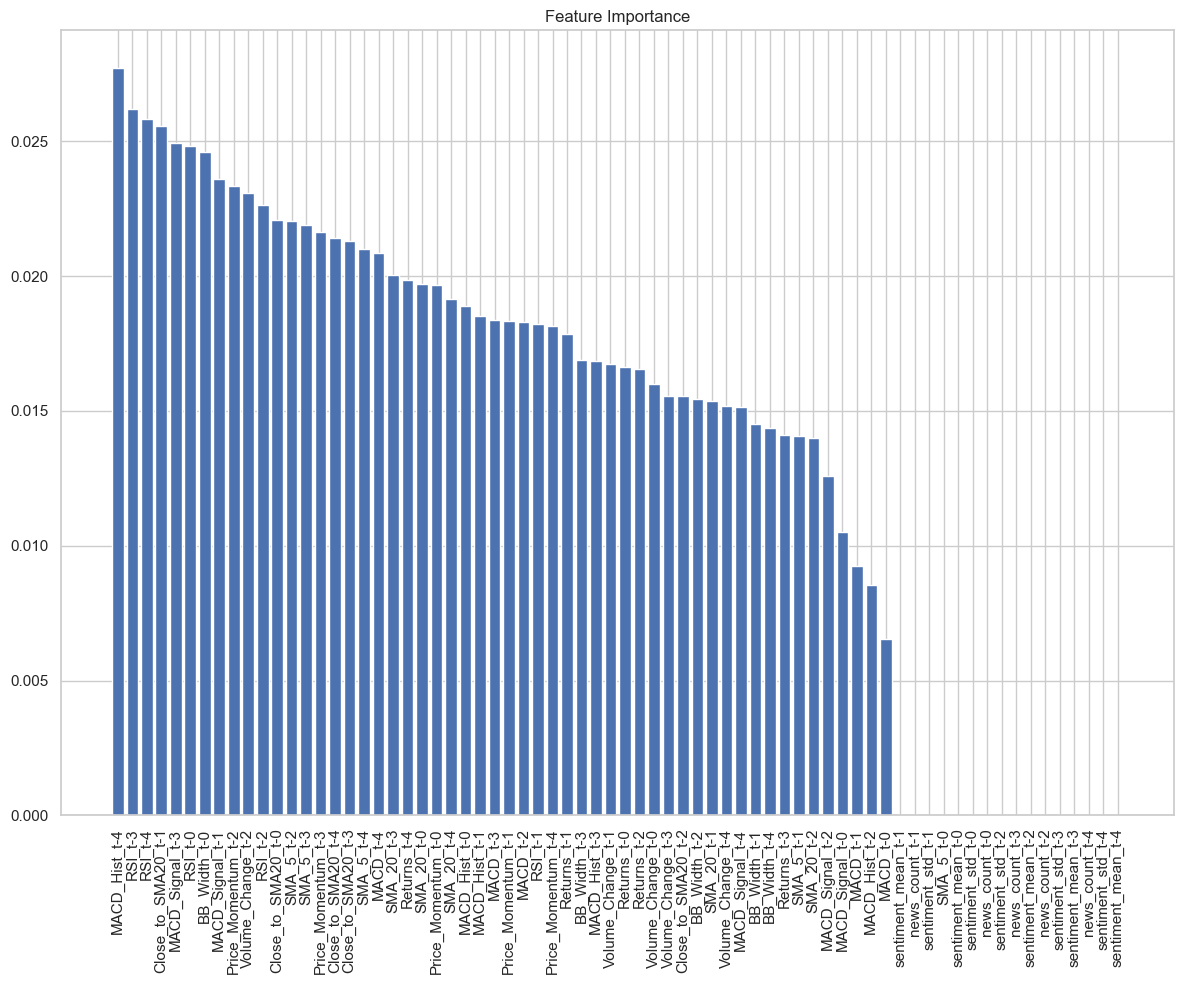


Top 20 most important features:
MACD_Hist_t-4: 0.0277
RSI_t-3: 0.0262
RSI_t-4: 0.0258
Close_to_SMA20_t-1: 0.0256
MACD_Signal_t-3: 0.0249
RSI_t-0: 0.0248
BB_Width_t-0: 0.0246
MACD_Signal_t-1: 0.0236
Price_Momentum_t-2: 0.0233
Volume_Change_t-2: 0.0231
RSI_t-2: 0.0226
Close_to_SMA20_t-0: 0.0221
SMA_5_t-2: 0.0220
SMA_5_t-3: 0.0219
Price_Momentum_t-3: 0.0216
Close_to_SMA20_t-4: 0.0214
Close_to_SMA20_t-3: 0.0213
SMA_5_t-4: 0.0210
MACD_t-4: 0.0209
SMA_20_t-3: 0.0200


In [58]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Flatten the sequence data for XGBoost
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Set up hyperparameter grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Create the base model - note the removal of use_label_encoder parameter
base_model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss'
)

# Set up cross-validation with stratified sampling
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optional: If you want to run a full grid search (takes time)
# Uncomment this section if you want to run the full grid search
"""
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_flat, y_train)

# Print the best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Use the best model from grid search
best_model = grid_search.best_estimator_
"""

# For quicker execution, use a manual selection of better parameters
# based on common XGBoost best practices

model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    objective='binary:logistic',
    random_state=42,
    eval_metric=['logloss', 'auc', 'error'],  # Specify eval_metric here in the constructor
    early_stopping_rounds=50 # Specify early_stopping_rounds here in the constructor
)

# Create evaluation sets
eval_set = [(X_train_flat, y_train), (X_test_flat, y_test)]

# Train the model with early stopping
# Removed early_stopping_rounds from the fit method call
model.fit(
    X_train_flat, 
    y_train, 
    eval_set=eval_set,
)

# Get the best number of trees
best_iteration = model.best_iteration
print(f"Best iteration: {best_iteration}")

# Evaluate the model
y_pred = model.predict(X_test_flat)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Get feature importance
feature_names_flat = [f"{features[j%len(features)]}_t-{5-i}" for i in range(1, 6) for j in range(len(features))]
importance = model.feature_importances_

# Sort feature importances
indices = np.argsort(importance)[::-1]

# Plot feature importance
plt.figure(figsize=(12, 10))
plt.title('Feature Importance')
plt.bar(range(len(importance)), importance[indices], align='center')
plt.xticks(range(len(importance)), [feature_names_flat[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# Display top 20 most important features
print("\nTop 20 most important features:")
for i in range(20):
    print(f"{feature_names_flat[indices[i]]}: {importance[indices[i]]:.4f}")

## 7. Model Interpretation with SHAP

Let's use SHAP to understand which features are most important for our predictions.

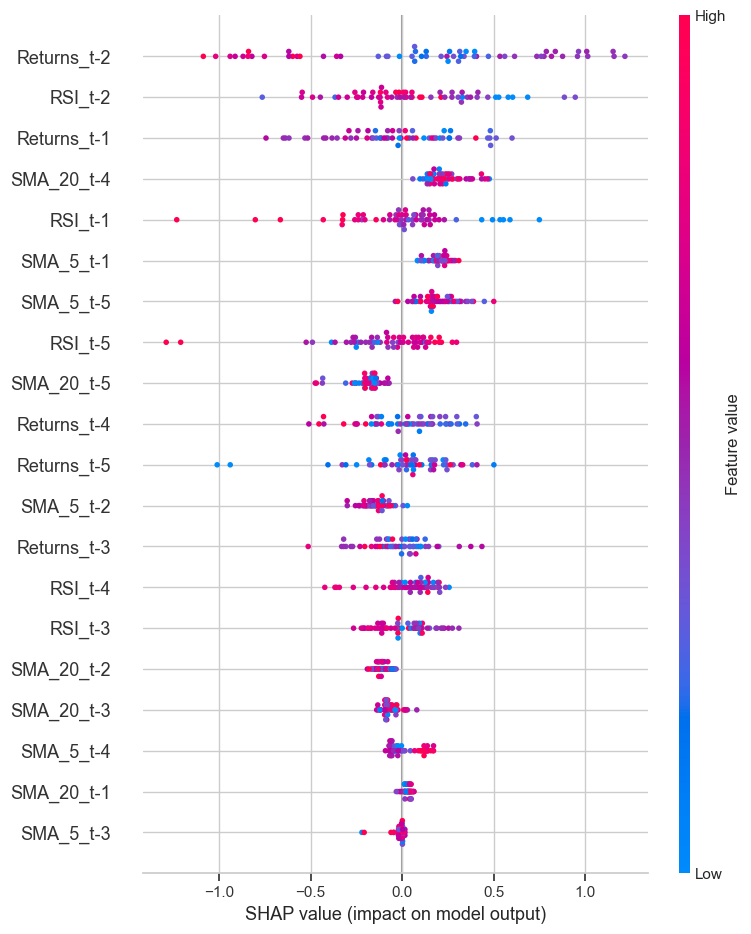

In [ ]:
# Calculate SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_test_flat)

# Reshape feature names for flattened data
feature_names = [f"{f}_t-{i}" for i in range(5, 0, -1) for f in features]

# Plot SHAP summary
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_flat, feature_names=feature_names)

## 8. Next Steps

Here's what we've accomplished so far:
1. Set up data collection for stock prices
2. Implemented news sentiment analysis using FinBERT
3. Created a basic news scraper (mock implementation)
4. Combined stock data with sentiment scores
5. Implemented a baseline XGBoost model
6. Added model interpretation with SHAP

Next steps to complete the project:
1. Implement a more robust news scraping or API integration
2. Create LSTM or Transformer models for time series prediction
3. Optimize model hyperparameters
4. Develop a Streamlit dashboard for visualization and prediction
5. Add real-time data updates
6. Implement model deployment

## 9. Sample Dashboard Implementation

Here's a sketch of how we could implement a Streamlit dashboard for this project.

In [ ]:
# Sample Streamlit dashboard code
# Save this to a file named app.py in the root directory

'''
import streamlit as st
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime, timedelta
import yfinance as yf
import pickle
import shap
from src.models.sentiment_analyzer import SentimentAnalyzer

# Page config
st.set_page_config(
    page_title="NSEnse - Stock Movement Predictor",
    page_icon="📈",
    layout="wide"
)

# Load pre-trained model and sentiment analyzer
# @st.cache_resource
def load_model():
    model = pickle.load(open("models/xgboost_model.pkl", "rb"))
    return model

# @st.cache_resource
def load_sentiment_analyzer():
    return SentimentAnalyzer()

# App header
st.title("NSEnse: Indian Stock Movement Predictor")
st.markdown("Predict stock movements using news sentiment and historical prices")

# Sidebar
st.sidebar.header("Input Parameters")

# Stock selection
nifty50 = ["RELIANCE.NS", "TCS.NS", "HDFCBANK.NS", "INFY.NS", "ICICIBANK.NS"]
stock = st.sidebar.selectbox("Select Stock", nifty50)

# Date range selection
end_date = datetime.now().date()
start_date = end_date - timedelta(days=365)
start_date = st.sidebar.date_input("Start Date", start_date)
end_date = st.sidebar.date_input("End Date", end_date)

if st.sidebar.button("Get Prediction"):
    # This would be replaced with actual model prediction
    st.info("Fetching data and making predictions...")
    
    # Main content area with tabs
    tab1, tab2, tab3 = st.tabs(["Stock Analysis", "Sentiment Analysis", "Prediction"])
    
    with tab1:
        st.header("Stock Price Analysis")
        # Fetch stock data
        data = yf.download(stock, start=start_date, end=end_date)
        # Plot stock data
        fig = go.Figure()
        fig.add_trace(go.Candlestick(
            x=data.index,
            open=data["Open"],
            high=data["High"],
            low=data["Low"],
            close=data["Close"],
            name="Price"
        ))
        st.plotly_chart(fig, use_container_width=True)
    
    with tab2:
        st.header("News Sentiment Analysis")
        # This would be real news data in the actual app
        news = pd.DataFrame({
            "date": pd.date_range(end=end_date, periods=5, freq="D"),
            "headline": [
                f"{stock.split('.')[0]} reports strong earnings",
                f"{stock.split('.')[0]} announces expansion plans",
                f"{stock.split('.')[0]} faces regulatory scrutiny",
                f"{stock.split('.')[0]} partners with tech giant",
                f"{stock.split('.')[0]} declares dividend"
            ]
        })
        
        # Analyze sentiment
        sentiment_analyzer = load_sentiment_analyzer()
        results = sentiment_analyzer.analyze(news["headline"].tolist())
        sentiment_df = pd.DataFrame(results)
        news["sentiment"] = sentiment_df["sentiment_score"]
        news["label"] = sentiment_df["label"]
        
        # Display sentiment over time
        fig = px.bar(
            news, 
            x="date", 
            y="sentiment", 
            color="label",
            hover_data=["headline"],
            title="News Sentiment Over Time"
        )
        st.plotly_chart(fig, use_container_width=True)
        
        # Display news table
        st.dataframe(news[["date", "headline", "label", "sentiment"]])
    
    with tab3:
        st.header("Price Movement Prediction")
        
        # This would be real prediction in the actual app
        prediction = np.random.choice(["Up", "Down"], p=[0.6, 0.4])
        confidence = np.random.uniform(0.6, 0.9)
        
        col1, col2 = st.columns(2)
        with col1:
            st.metric(
                label="Predicted Direction", 
                value=prediction,
                delta="+2.5%" if prediction == "Up" else "-1.8%"
            )
        
        with col2:
            st.metric(
                label="Model Confidence", 
                value=f"{confidence:.2f}"
            )
        
        st.subheader("Feature Importance")
        # This would be real SHAP values in the actual app
        feature_importance = {
            "Sentiment": 0.35,
            "Price Trend": 0.25,
            "Volume": 0.15,
            "News Count": 0.10,
            "RSI": 0.08,
            "SMA Crossover": 0.07
        }
        
        fig = px.bar(
            x=list(feature_importance.values()),
            y=list(feature_importance.keys()),
            orientation="h",
            title="Feature Importance"
        )
        st.plotly_chart(fig, use_container_width=True)
'''